## Análisis de datos Proyecto LINT

### Bibliotecas y rutas de archivos



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/')

In [3]:
import importlib
import pylint, glob
from ipywidgets import interact

%matplotlib inline

In [4]:
!pip install mpld3

import mpld3
#mpld3.enable_notebook()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 4.7 MB/s eta 0:00:00


In [5]:
path_SEAD =  "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/datos_SEAD/datos_exportados_reactor.csv"
path_step = "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/step_t_min_05Jul2024.txt"
path_LINT_list = glob.glob(r"/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/datos_LINT/2024-07-05*.log")
path_stable = "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/step_stable_05Jul2024.txt"

fecha_ensayo = '05Jul2024'

Power_list = ['100', '300', '1600', '8000', '0.5M', '1M', '2M', '4M', '7.5M']

### Datos SEAD y LINT

Grafico datos del SEAD a partir del .csv generado por el software de exportación del RA-3. Corresponden a las corrientes de Marcha 2 y 3 en función del tiempo.

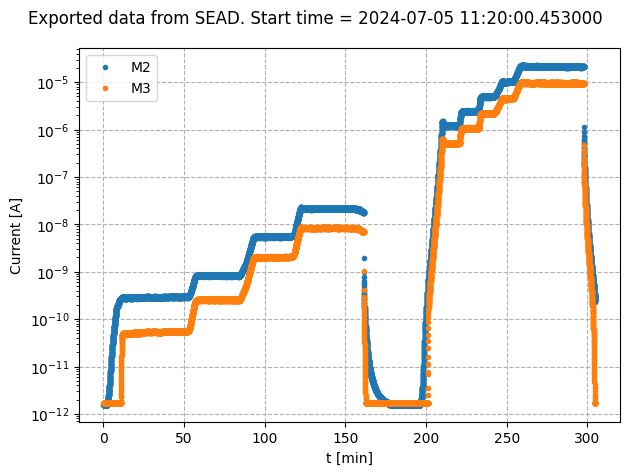

In [6]:
datos_sead = pylint.data_sead(path_SEAD, fecha_ensayo)
figure_SEAD = pylint.figure_SEAD(datos_sead, ['M2', 'M3'])

Los separo en intervalos convenientes, definido según el step que decida previamente.

In [7]:
t_SEAD_step, current_M2_step = datos_sead.per_step('M2', path_step, power_list = Power_list)
_, current_M3_step = datos_sead.per_step('M3', path_step, power_list = Power_list)

Llamo los datos del LINT, y le aplico el factor de corrección al promedio para mediciones repetidas con un período de sampleo menor a 1 segundo.

In [8]:
data_LINT = pylint.data_LINT(path_LINT_list =path_LINT_list, path_step = path_step, t_inicio=datos_sead.t_inicio, power_list= Power_list)
data_LINT.corr_rep()

### Estudio de derivas

Calculo la deriva móvil para cada escalón de los datos del LINT. Sólo ingrese la cantidad de puntos por promedio que se quieren tener en cuenta (default = 10). El error por cortes de datos se toma en cuenta.

In [9]:
LINT_t_deriva, LINT_count_deriva = data_LINT.moving_avg()

Gráficos de las derivas en los escalones elegidos en *power_sel*.

Text(0, 0.5, 'Error relativo %')

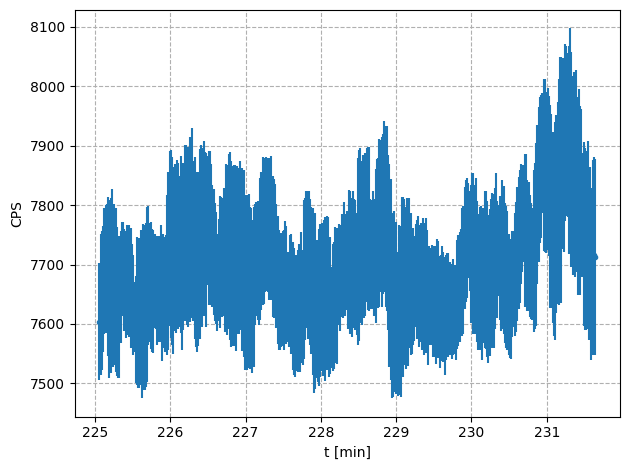

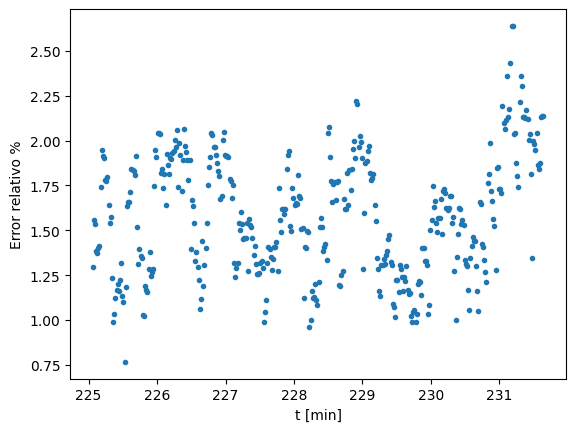

In [10]:
fig_LINT_deriva, ax_deriva = pylint.figure_LINT_err(LINT_t_deriva, LINT_count_deriva, power_sel = ['1M'], yscale = 'linear')
fig, ax = pylint.plt.subplots()
ax.plot(LINT_t_deriva['1M'], 100*LINT_count_deriva['1M'][:, 1]/LINT_count_deriva['1M'][:, 0], '.')
ax.set_xlabel('t [min]')
ax.set_ylabel('Error relativo %')

Mirando las derivas en cuentas y comparándolas con las derivas en corriente, se elige para cada escalón un nuevo intervalo donde se note cierta estabilidad.

In [11]:
stable_times = pylint.np.loadtxt(path_stable)
#fig_stable_sel = pylint.add_vlines(fig_LINT_deriva, ax_deriva, stable_times.reshape(-1))
#fig_stable_sel.show()
#La idea de esta función era graficar las lineas punteadas que definen los intervalos estables
stable_times

array([[ 20. ,  45. ],
       [ 60. ,  73. ],
       [100. , 110. ],
       [135. , 145. ],
       [214.5, 218. ],
       [226. , 230. ],
       [235.5, 239.5],
       [248.5, 250.5],
       [275. , 285. ]])

In [12]:
data_LINT.stable_interval(path_stable) #Agrego los escalones en intervalos estables.
data_LINT.potencias

['100', '300', '1600', '8000', '0.5M', '1M', '2M', '4M', '7.5M']

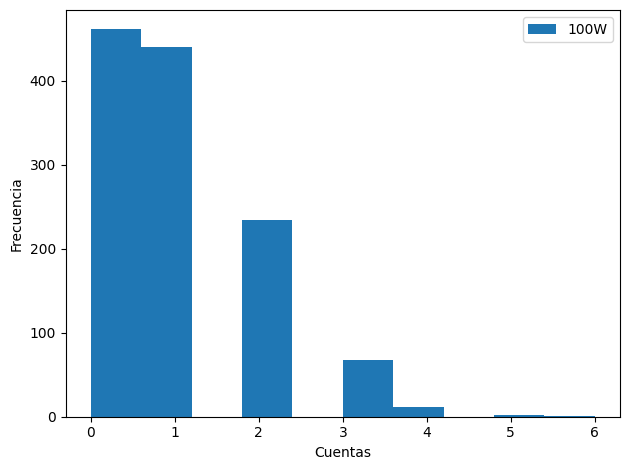

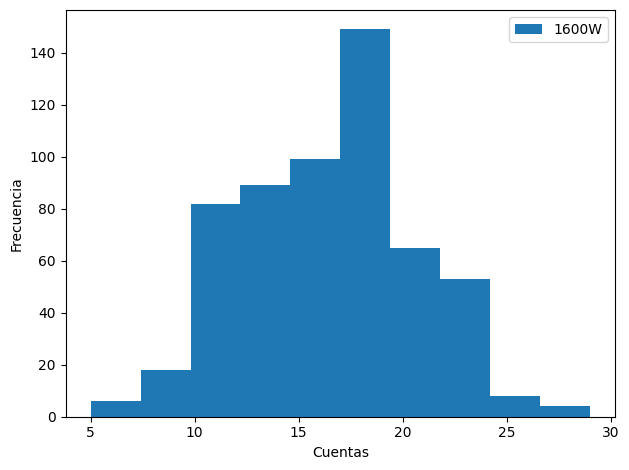

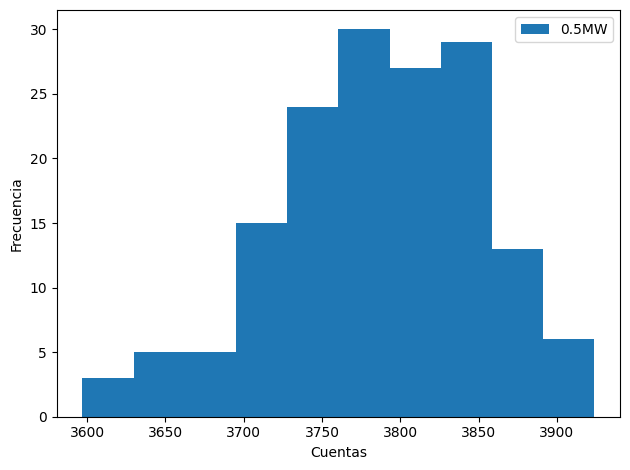

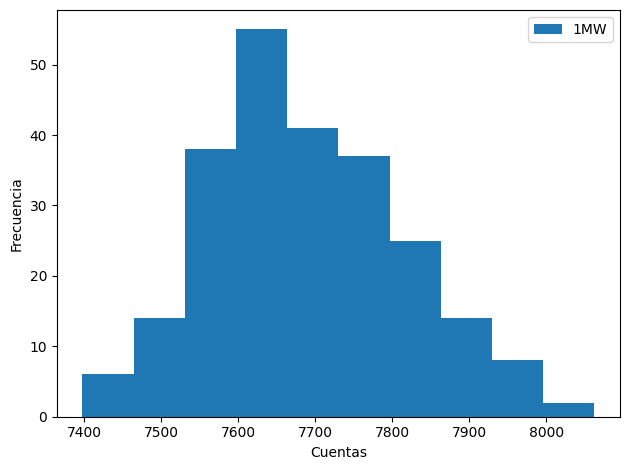

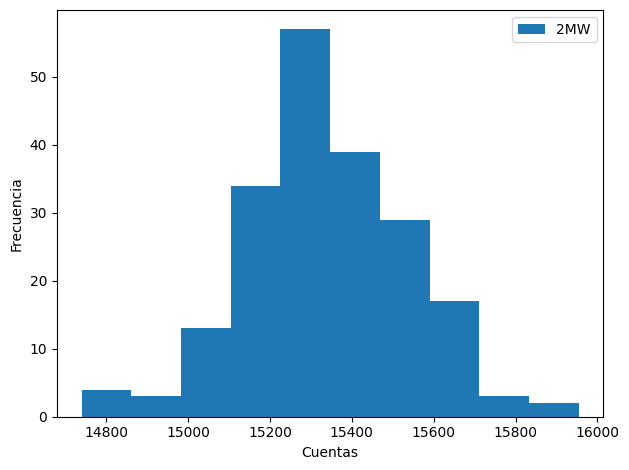

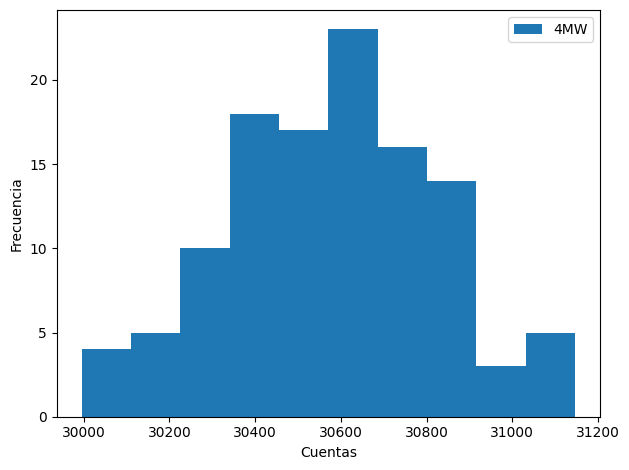

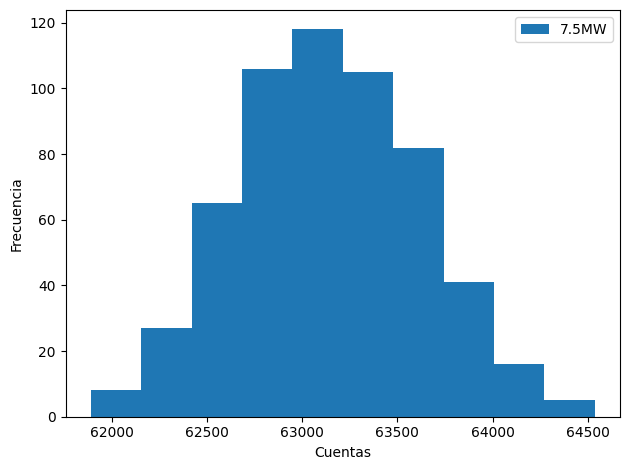

In [13]:
pylint.LINT_hist_step(data_LINT, ['100', '1600', '0.5M', '1M', '2M', '4M', '7.5M']) #Grafico los histogramas para el escalón estable en la potencia definida.

### Promedio por escalón

Promedio en cada intervalo, tanto en corrientes de las Marchas como en cuentas del LINT.

In [14]:
LINT_avg = pylint.average_stable(data_LINT.time_norep, data_LINT.counts_norep, stable_times)
M3_avg = pylint.average_stable(t_SEAD_step, current_M3_step, stable_times)
M2_avg = pylint.average_stable(t_SEAD_step, current_M2_step, stable_times)

Comparo las fluctuaciones poissonianas por promedio, $\sqrt{N_{mean}}$, con la incerteza estadística.

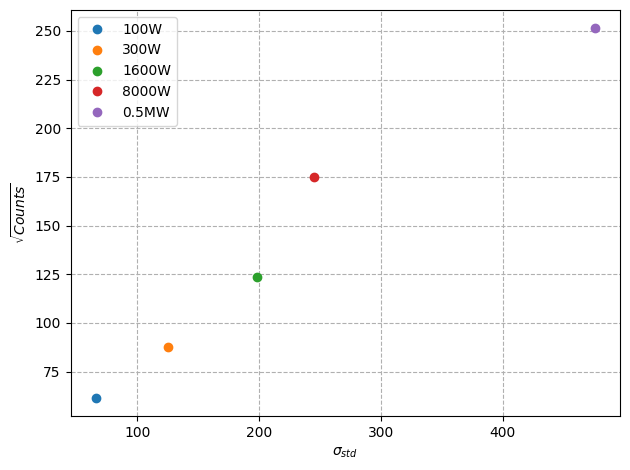

In [16]:
pylint.fig_err(LINT_avg[:, 1][4:], LINT_avg[:, 0][4:], scale= 'linear', power_list=Power_list)

Arrastro los errores en corriente a las incertezas por cuentas mediante incertezas efectivas:

$$\frac{\Delta y_{eff}}{y} = \sqrt{(\frac{\Delta y}{y})^2 + (\frac{\Delta x}{x})^2}$$

donde *y* corresponde a las cuentas, y *x*, a la corriente.

In [17]:
y_M2_err = pylint.np.sqrt(LINT_avg[:, 1]**2 + (LINT_avg[:, 0]*M2_avg[:, 1]/M2_avg[:, 0])**2)
y_M3_err = pylint.np.sqrt(LINT_avg[:, 1]**2 + (LINT_avg[:, 0]*M3_avg[:, 1]/M3_avg[:, 0])**2)

### Ajuste lineal

In [18]:
focus_on = [-5, -2] #Últimos cinco escalones, excepto el último (-1)

In [19]:
ajuste_LINT_M2 = pylint.ajuste_pol(grado = 1, xdata = M2_avg[:, 0], ydata= LINT_avg[:, 0], y_err = LINT_avg[:, 1], i_sel = focus_on)
ajuste_LINT_M3 = pylint.ajuste_pol(grado = 1, xdata = M3_avg[:, 0], ydata= LINT_avg[:, 0], y_err = LINT_avg[:, 1], i_sel = focus_on)
#Recuerdo: coef, perr, chi2, res, pvalor, ddof, rhos, var_mu = ajuste_LINT

Fit Report: 
a = 3081000000±26600000 
b = 128±79 
p-valor = 0.5755259939567406
chi2 = 1.104941768470231
dof = 2



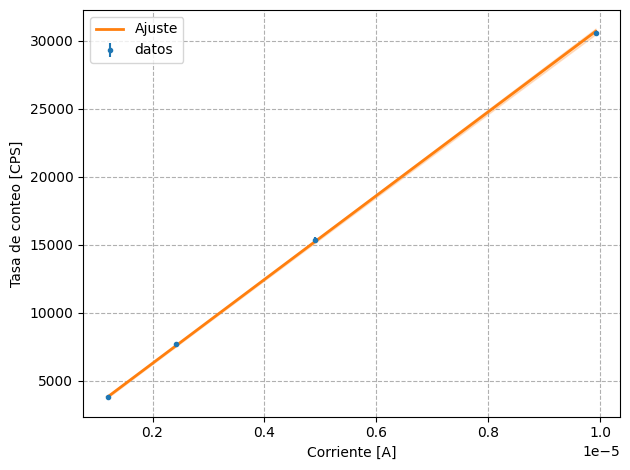

In [20]:
pylint.figure_fit(M2_avg[:, 0], LINT_avg[:, 0], LINT_avg[:, 1], ajuste_LINT_M2, i_sel = focus_on, scale = 'linear', show_report = True)

Fit Report: 
a = 6877000000±59400000 
b = 295±78 
p-valor = 0.6051679548319456
chi2 = 1.0044984963714163
dof = 2



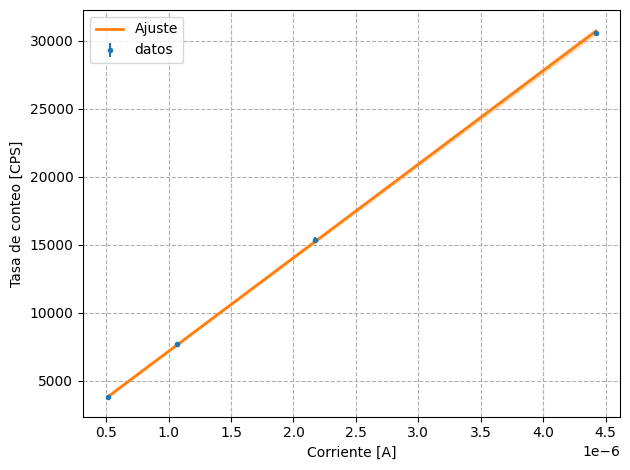

In [21]:
pylint.figure_fit(M3_avg[:, 0], LINT_avg[:, 0], LINT_avg[:, 1], ajuste_LINT_M3, i_sel = focus_on, scale = 'linear', show_report = True)

Tiene sentido que en escala logarítmica de base 10 las pendientes sean parecidas? Veamos que:

In [22]:
print('m_M2 ~', pylint.np.log10(3.085*1e9), '≈' , 'm_M3 ~', pylint.np.log10(6.993*1e9))

m_M2 ~ 9.48925516836926 ≈ m_M3 ~ 9.84466352824024


### Counts($t_i$) vs Current($t_i$)

Veo lo que pasa con los distintos pares ordenados ($CPS(t_i), I(t_i)$) en cada escalón.
Para eso me hice una nueva función que chequea que los tiempos para cada par coincidan (las de CPS pueden tener cortes), y en base a eso grafiqué por escalón:

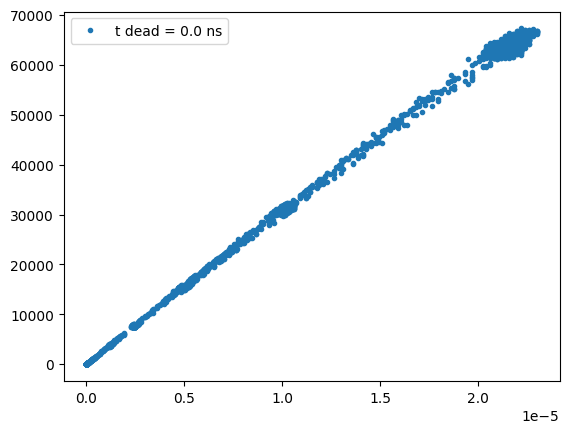

In [23]:
## veo los escalones con rampas anteriores, y los SCRAMs
path_step = "/content/drive/MyDrive/Colab Notebooks/ProyectoLINTatPromptGamma/step_t_min_05Jul2024_conrampas.txt"
Power_list = ['100', '300', '1600', '8000', 'SCRAM 1', '0.5M', '1M', '2M', '4M', '7.5M', 'SCRAM 2']

pow_sel = ['100', '300', '1600', '8000', '0.5M', '1M', '2M', '4M', '7.5M']
#['100', '300', '1600', '8000']

tdead = 0

#divido las señales de las Marchas
t_SEAD_step, current_M2_step = datos_sead.per_step('M2', path_step, power_list = Power_list)
_, current_M3_step = datos_sead.per_step('M3', path_step, power_list = Power_list)

#las del LINT
data_LINT = pylint.data_LINT(path_LINT_list =path_LINT_list, path_step = path_step, t_inicio=datos_sead.t_inicio, power_list= Power_list)
data_LINT.corr_rep()

data_LINT.corr_nonpar(tdead)
figure_par, totalcounts_M2, totalcurrent_M2, t_M2LINT = pylint.fig_LINT_MX_tuple(data_LINT.counts_corr, data_LINT.time_norep, current_M2_step, t_SEAD_step, power_sel = pow_sel)
pylint.plt.close()
pylint.plt.figure(1)
pylint.plt.plot(totalcurrent_M2, totalcounts_M2, '.', label='t dead = {} ns'.format(tdead*1e9))
pylint.plt.legend()
#mpld3.enable_notebook()

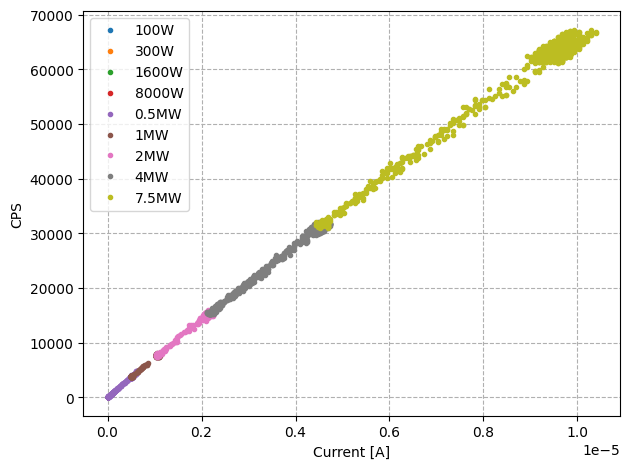

In [25]:
figure_par, totalcounts_M3, totalcurrent_M3, _ = pylint.fig_LINT_MX_tuple(data_LINT.counts_norep, data_LINT.time_norep, current_M3_step, t_SEAD_step, power_sel = pow_sel)
figure_par.show()

In [26]:
#Criterios de selección
i_cut_M2 = pylint.np.where(totalcurrent_M2<2.0e-5)[0][-1]
j_cut_M2 = pylint.np.where(totalcurrent_M2>2.5e-8)[0][0]

i_cut_M3 = pylint.np.where(totalcurrent_M3<0.9e-5)[0][-1]
j_cut_M3 = pylint.np.where(totalcurrent_M3>0.9e-8)[0][0]


#Ajustes para pares ord
ajuste_par_M2_h, cov_M2_h = pylint.np.polyfit(totalcurrent_M2[j_cut_M2:i_cut_M2], totalcounts_M2[j_cut_M2:i_cut_M2], 1, cov=True)
ajuste_par_M3_h, cov_M3_h = pylint.np.polyfit(totalcurrent_M3[j_cut_M3:i_cut_M3], totalcounts_M3[j_cut_M3:i_cut_M3], 1, cov=True)

ajuste_par_M2_l, cov_M2_l = pylint.np.polyfit(totalcurrent_M2[:j_cut_M2], totalcounts_M2[:j_cut_M2], 1, cov=True)
ajuste_par_M3_l, cov_M3_l = pylint.np.polyfit(totalcurrent_M3[:j_cut_M3], totalcounts_M3[:j_cut_M3], 1, cov=True)

#Los ajustes de antes me devuelven Singular matrix (chequear)
#ajuste_par_M2 = pylint.ajuste_pol(grado = 1, ydata = totalcounts_M2[j_cut_M2:i_cut_M2], xdata= totalcurrent_M2[j_cut_M2:i_cut_M2], y_err= pylint.np.sqrt(totalcounts_M2[j_cut_M2:i_cut_M2]))
#ajuste_par_M3 = pylint.ajuste_pol(grado = 1, ydata = totalcounts_M2[j_cut_M3:i_cut_M3], xdata= totalcurrent_M3[j_cut_M3:i_cut_M3], y_err= pylint.np.sqrt(totalcounts_M3[j_cut_M3:i_cut_M3]))


Intervalo de corriente seleccionado: [2.57353839e-08 1.94915895e-05]
parámetros altas pot (m, b): 3038448659.5792127 281.7623688870397
parámetros bajas pot (m, b): 3069170769.6966686 0.016063684461306384


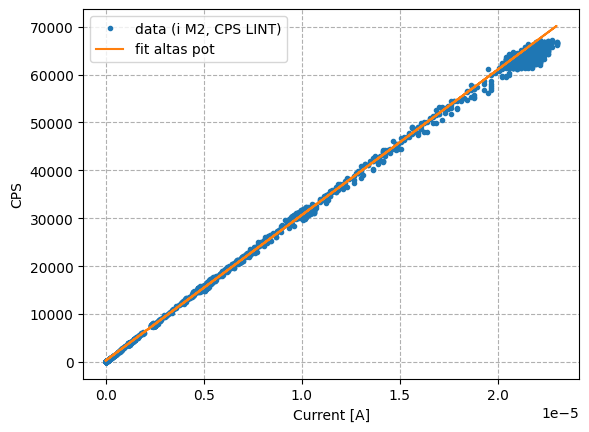

In [27]:
#Gráficos
pylint.plt.figure()
pylint.plt.plot(totalcurrent_M2, totalcounts_M2, '.', label='data (i M2, CPS LINT)')
pylint.plt.plot(totalcurrent_M2, pylint.np.polyval(ajuste_par_M2_h, totalcurrent_M2), label = 'fit altas pot')
#pylint.plt.plot(totalcurrent_M2, pylint.np.polyval(ajuste_par_M2_l, totalcurrent_M2), label = 'fit bajas pot')
pylint.plt.legend()
pylint.plt.xlabel('Current [A]')
pylint.plt.ylabel('CPS')
pylint.plt.grid(ls='--')

print('Intervalo de corriente seleccionado:', totalcurrent_M2[[j_cut_M2, i_cut_M2]])
print('parámetros altas pot (m, b):', *ajuste_par_M2_h)
print('parámetros bajas pot (m, b):', *ajuste_par_M2_l)

Intervalo de corriente seleccionado: [9.17260466e-09 8.93619834e-06]
parámetros altas pot (m, b): 6767341873.65284 465.99132981472843
parámetros bajas pot (m, b): 7853411404.238242 0.5623235527624992


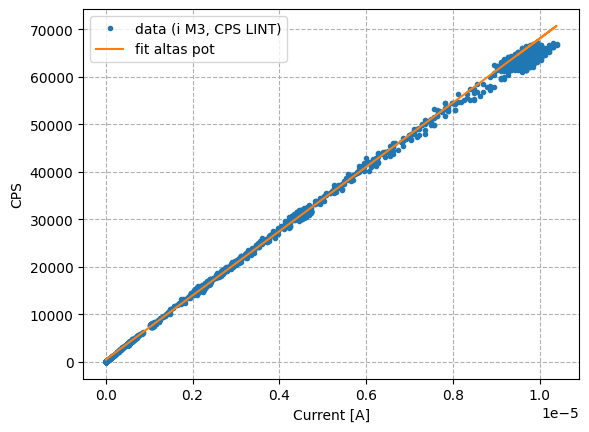

In [28]:
pylint.plt.figure()
pylint.plt.plot(totalcurrent_M3, totalcounts_M3, '.', label='data (i M3, CPS LINT)')
pylint.plt.plot(totalcurrent_M3, pylint.np.polyval(ajuste_par_M3_h, totalcurrent_M3), label = 'fit altas pot')
#pylint.plt.plot(totalcurrent_M3, pylint.np.polyval(ajuste_par_M3_l, totalcurrent_M3), label = 'fit bajas pot')
pylint.plt.legend()
pylint.plt.xlabel('Current [A]')
pylint.plt.ylabel('CPS')
pylint.plt.grid(ls='--')

print('Intervalo de corriente seleccionado:', totalcurrent_M3[[j_cut_M3, i_cut_M3]])
print('parámetros altas pot (m, b):', *ajuste_par_M3_h)
print('parámetros bajas pot (m, b):', *ajuste_par_M3_l)

### **Calculo de residuos:**

In [29]:
res_M3_l = pylint.np.polyval(ajuste_par_M3_l, totalcurrent_M3[:j_cut_M3]) - totalcounts_M3[:j_cut_M3]
res_M2_l = pylint.np.polyval(ajuste_par_M2_l, totalcurrent_M2[:j_cut_M2]) - totalcounts_M2[:j_cut_M2]

res_M3_h = pylint.np.polyval(ajuste_par_M3_h, totalcurrent_M3[j_cut_M3:i_cut_M3]) - totalcounts_M3[j_cut_M3:i_cut_M3]
res_M2_h = pylint.np.polyval(ajuste_par_M2_h, totalcurrent_M2[j_cut_M2:i_cut_M2]) - totalcounts_M2[j_cut_M2:i_cut_M2]

Text(0, 0.5, 'Frecuencia')

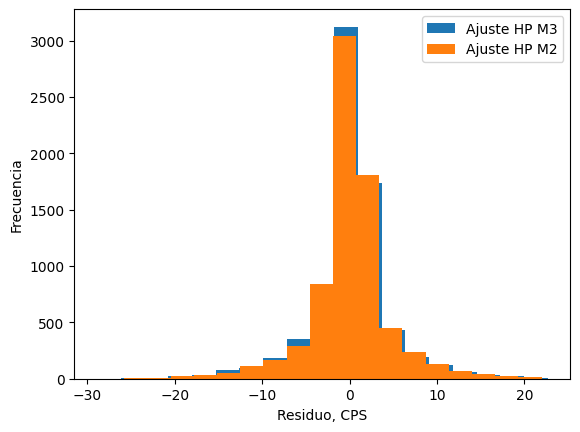

In [30]:
from pylint import plt
plt.figure()
plt.hist(res_M3_l, bins=int(len(res_M3_l)**(1/3)), label = 'Ajuste HP M3')
plt.hist(res_M2_l, bins=int(len(res_M2_l)**(1/3)), label = 'Ajuste HP M2')
plt.legend()
plt.xlabel('Residuo, CPS')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

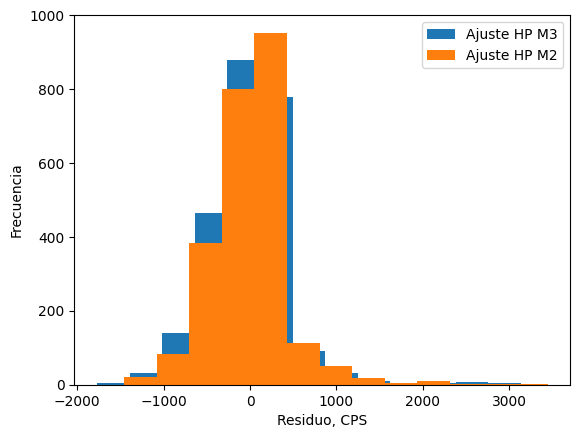

In [31]:
plt.figure()
plt.hist(res_M3_h, bins=int(len(res_M3_h)**(1/3)), label = 'Ajuste HP M3')
plt.hist(res_M2_h, bins=int(len(res_M2_h)**(1/3)), label = 'Ajuste HP M2')
plt.legend()
plt.xlabel('Residuo, CPS')
plt.ylabel('Frecuencia')